# Build/save classifier

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [14]:
diss = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_ff_random_order_disson_1.pkl"
)

quest_order = pd.read_csv(
    "disson_global/core/disson_global_core_with_actual_ff_random_order_1.csv"
)["0"]

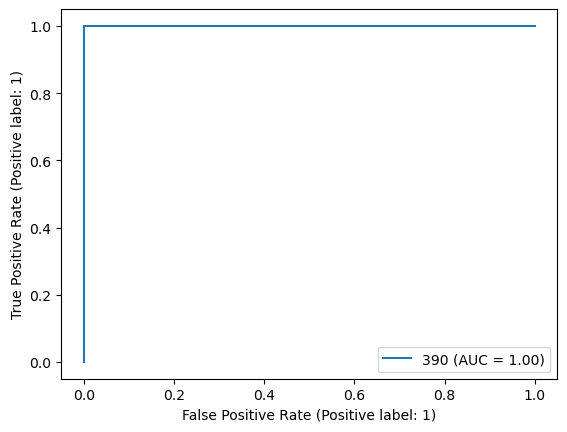

In [16]:
groups = ["qsampled", "runif"]

questions_asked = 390
data = _diss_dataset(diss, questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

classifier.question_order = quest_order

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [18]:
pd.to_pickle(classifier, "tst_classifier.pkl")

# Use saved classifier on data

In [30]:
classifier = pd.read_pickle("tst_classifier.pkl")

In [35]:
data = pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")
data_fmtd = (
    data.iloc[:, classifier.question_order.values]
    .fillna(-9)
    .astype(int)
    .replace(-9, np.nan)
    .to_numpy()
)

data_fmtd

array([[nan, nan, nan, ...,  1., nan, nan],
       [nan, nan, nan, ...,  1., nan, nan],
       [nan, nan, nan, ...,  1., nan, nan],
       ...,
       [nan, nan, nan, ...,  1., nan, nan],
       [nan, nan, nan, ...,  1., nan, nan],
       [ 1., nan, nan, ...,  1., nan, nan]])

In [36]:
classifier.predict(data_fmtd)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values